<a href="https://colab.research.google.com/github/egagli/amath563/blob/main/labs/5/Lab5_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement AlexNet in PyTorch, achieve greater than 85% accuracy within 10 epochs on the Dogs and Cats classification task.

In [2]:
import torch
import torchvision
from torch import nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm
from sklearn.model_selection import train_test_split
import zipfile
import glob
from PIL import Image
import cv2 as cv
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
batch_size = 64

In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda0 = torch.device('cuda:0')

1
Tesla T4


In [5]:
# dataloading adapted from https://www.kaggle.com/code/lys620/basic-pytorch-cnn-tutorial/notebook
base_dir = '/content/drive/MyDrive/class/deep_learning_data/'
train_dir = '/content/drive/MyDrive/class/deep_learning_data/lab5/data/train/train'
test_dir = '/content/drive/MyDrive/class/deep_learning_data/lab5/data/test/test'
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
print(f'Length of training data: {len(train_list)}')
print(f'Length of test data: {len(test_list)}')
train_list, val_list = train_test_split(train_list, test_size=0.2)
#data Augumentation
train_transforms =  transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #https://pytorch.org/hub/pytorch_vision_alexnet/
    ])

val_transforms = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms_not_normalized = transforms.Compose([   
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
    #dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    #load an one of images
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
test_data_not_normalized = dataset(test_list, transform=test_transforms_not_normalized)
val_data = dataset(val_list, transform=test_transforms)
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)
test_loader_not_normalized = torch.utils.data.DataLoader(dataset = test_data_not_normalized, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

Length of training data: 25000
Length of test data: 12500


In [9]:
class AlexNet(nn.Module):
    """
    Neural network model consisting of layers propsed by AlexNet paper.
    """
    def __init__(self, num_classes=2):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()

        # input image 227x227x3

        self.net = nn.Sequential(
        # layer1
        nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0), # 55x55x96
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2), # 27x27x96

        # layer 2
        nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2), # 27x27x256
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2), # 13x13x256

        # layer 3
        nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1), # 13x13x384
        nn.ReLU(),

        # layer 4
        nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1), # 13x13x384
        nn.ReLU(),

        # layer 5
        nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1), # 13x13x256
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2), #, # 6x6x256

        # flattening
        nn.Flatten(),

        # layer 6
        nn.Dropout(0.5),
        nn.Linear(9216, 4096),
        nn.ReLU(),

        # layer 7
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),

        # layer 8
        nn.Linear(4096, num_classes))

    def forward(self, x):
        return self.net(x)

In [10]:
#Definition of hyperparameters
num_epochs = 10
# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# Adam Optimizer
model = AlexNet().to(cuda0)
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# initialize arrays to hold loss and accuracy data
train_loss_list = np.zeros((num_epochs,))
accuracy_list = np.zeros((num_epochs,))

for epoch in tqdm.trange(num_epochs):
  total_train_loss = 0
  total_val_loss = 0

  for imgs,labels in train_loader:
    # calculate training loss on model
    imgs = imgs.to(cuda0)
    labels = labels.to(cuda0)
    y_pred = model(imgs)
    loss = error(y_pred, labels)
    total_train_loss += loss
    
    # zero gradients, backwards pass, and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss_list[epoch] = total_train_loss/len(train_loader)


  # Calculate accuracy
  imgs_test, labels_test = next(iter(val_loader))
  imgs_test = imgs_test.to(cuda0)
  labels_test = labels_test.to(cuda0)
  #labels_test = labels_test.type(torch.FloatTensor).to(cuda0)
  with torch.no_grad():
    y_pred = model(imgs_test)
    correct = (torch.argmax(y_pred, dim=1) == labels_test).type(torch.FloatTensor)
    accuracy_list[epoch] = correct.mean()
  print(f'Epoch: {epoch+1}, Training Loss: {train_loss_list[epoch]:0.5f}, Accuracy: {accuracy_list[epoch]:0.5f}')

 10%|█         | 1/10 [02:00<18:08, 120.96s/it]

Epoch: 1, Training Loss: 0.64519, Accuracy: 0.68750


 20%|██        | 2/10 [04:01<16:03, 120.45s/it]

Epoch: 2, Training Loss: 0.50784, Accuracy: 0.73438


 30%|███       | 3/10 [06:00<14:01, 120.20s/it]

Epoch: 3, Training Loss: 0.40180, Accuracy: 0.75000


 40%|████      | 4/10 [08:00<11:59, 120.00s/it]

Epoch: 4, Training Loss: 0.33859, Accuracy: 0.85938


 50%|█████     | 5/10 [10:00<10:00, 120.11s/it]

Epoch: 5, Training Loss: 0.28139, Accuracy: 0.89062


 60%|██████    | 6/10 [12:01<08:00, 120.12s/it]

Epoch: 6, Training Loss: 0.24878, Accuracy: 0.95312


 70%|███████   | 7/10 [14:03<06:02, 120.82s/it]

Epoch: 7, Training Loss: 0.21679, Accuracy: 0.90625


 80%|████████  | 8/10 [16:09<04:05, 122.56s/it]

Epoch: 8, Training Loss: 0.19279, Accuracy: 0.92188


 90%|█████████ | 9/10 [18:17<02:04, 124.13s/it]

Epoch: 9, Training Loss: 0.16878, Accuracy: 0.95312


100%|██████████| 10/10 [20:24<00:00, 122.44s/it]

Epoch: 10, Training Loss: 0.15195, Accuracy: 0.93750


In [12]:
# save model
torch.save(model, '/content/drive/MyDrive/class/deep_learning_data/lab5/model/model_w_dropout.pt')
# load model
# model = torch.load(PATH)
# model.eval()

Text(0.5, 0.98, 'Optimizer: Adam \n lr = 0.001 epochs = 10 \n Max Accuracy = 0.953')

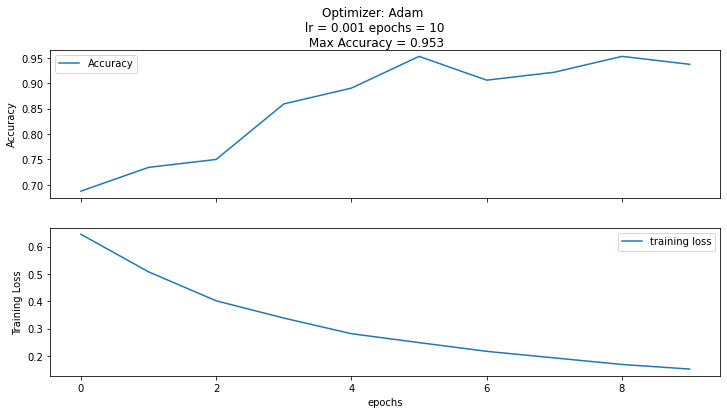

In [13]:
# plot test accuracy and training loss
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list,label='Accuracy')
ax1.set_ylabel("Accuracy")
ax1.legend()
ax2.plot(train_loss_list,label='training loss')
#ax2.plot(val_loss_list,label='validation loss')
ax2.legend()
ax2.set_ylabel("Training Loss")
ax2.set_xlabel("epochs");
fig.suptitle(f'Optimizer: Adam \n lr = 0.001 epochs = {num_epochs} \n Max Accuracy = {max(accuracy_list):.3f}')

In [14]:
# get images and labels for test set
imgs_test, labels_test = next(iter(test_loader))
imgs_test = imgs_test.to(cuda0)
with torch.no_grad():
  y_pred = model(imgs_test)

In [15]:
# get guesses
guesses = torch.argmax(y_pred, dim=1) 

In [16]:
# get probabilities
smax=nn.Softmax(dim=1)
probability,_ = torch.max(smax(y_pred),dim=1) 

In [17]:
imgs_test_not_normalized, labels_test_not_normalized = next(iter(test_loader_not_normalized))

Text(0.5, 0.98, 'AlexNet Cat/Dog Classification Test')

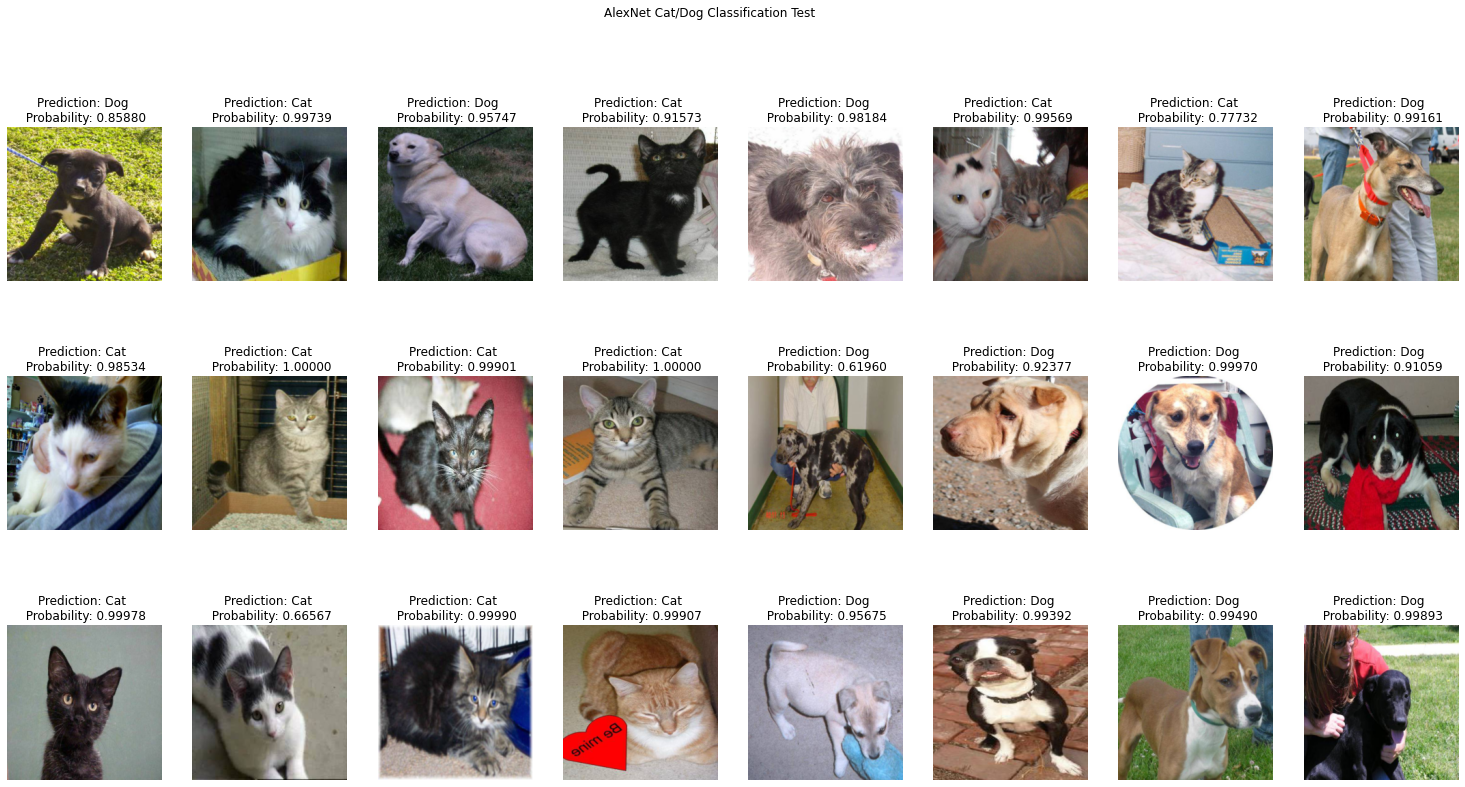

In [18]:
# plot classification accuracy
f,ax=plt.subplots(3,8,figsize=(26,13))
for i,(axs,predicted,true,prob) in enumerate(zip(ax.reshape(-1),guesses,labels_test,probability)):
  axs.imshow(imgs_test_not_normalized[i].permute(1,2,0))
  if predicted == 1:
            predicted='Dog'
  elif predicted == 0:
            predicted='Cat'
  axs.set_title(f'Prediction: {predicted} \n Probability: {prob:0.5f}')
  axs.axis('off')
f.suptitle('AlexNet Cat/Dog Classification Test')

# Visualize Feature Maps of some images

code adpated from https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/

In [41]:
# load the model
print(model)
model_weights = [] # we will save the conv layer weights in this list
conv_layers = [] # we will save the 49 conv layers in this list
# get all the model children as list
model_children = list(model.children())
model_children = model_children[0] 

AlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=9216, out_features=4096, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=4096, out_features=4096, bias=True

In [44]:
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
      counter += 1
      model_weights.append(model_children[i].weight)
      conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
      print('hi again')
      for j in range(len(model_children[i])):
          for child in model_children[i][j].children():
              if type(child) == nn.Conv2d:
                  counter += 1
                  model_weights.append(child.weight)
                  conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 5


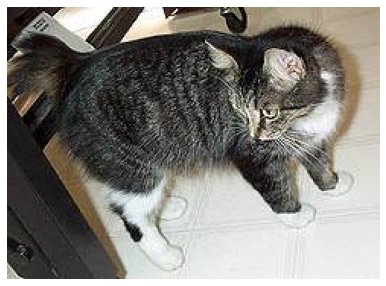

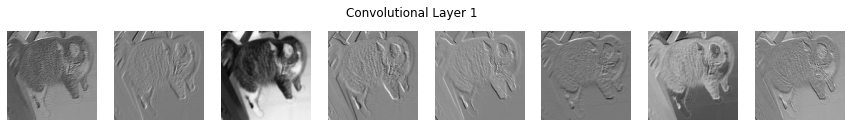

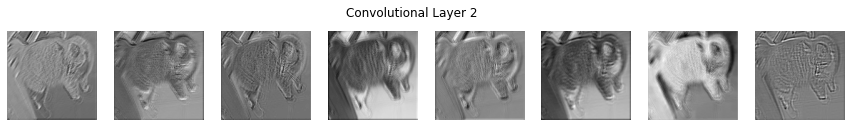

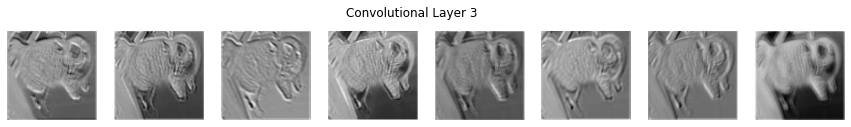

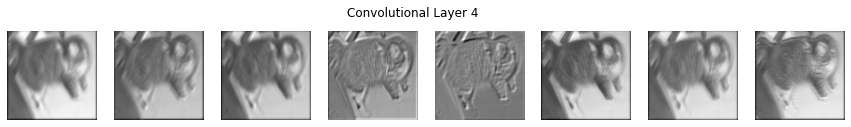

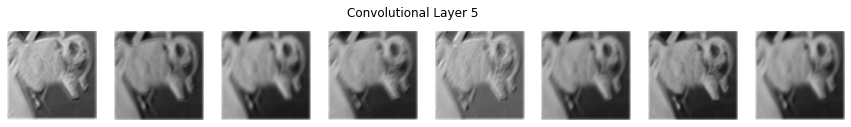

In [82]:
# read and visualize an image
img = cv.imread(train_list[3])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
f,ax=plt.subplots(figsize=(15,5))
ax.imshow(img)
ax.axis('off')
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img).to(cuda0)

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)

# pass the image through all the layers
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

# visualize 64 features from each layer 
# (although there are more feature maps in the upper layers)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(15, 2))
    plt.suptitle(f'Convolutional Layer {num_layer+1}')
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    for i, filter in enumerate(layer_viz):
        if i == 8: # we will visualize only 8 feature maps in each layer
            break
        plt.subplot(1, 8, i + 1)
        filter = filter.cpu()
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
